In [1]:
from pystac_client import Client
from shapely.geometry import Point

In [2]:
api_url = 'https://earth-search.aws.element84.com/v1'
collection = 'sentinel-2-c1-l2a'  # Sentinel-2, Level 2A
point = Point(27.95, 36.20)  # Rhodes

In [3]:
client = Client.open(api_url)
search = client.search(
    collections=[collection],
    intersects=point,
    datetime='2023-07-01/2023-08-31',
    query=['eo:cloud_cover<1']
)

In [4]:
search.matched()

11

In [5]:
items = search.item_collection()

In [6]:
items.save_object('rhodes.geojson')

In [8]:
# EPSG for vector data
items[0].properties['proj:epsg']

32635

In [14]:
item = items[0]

In [12]:
import rioxarray
import geopandas

In [15]:
rhodes = geopandas.read_file('rhodes.gpkg')
rhodes_reprojected = rhodes.to_crs(items[0].properties['proj:epsg'])
bbox = rhodes_reprojected.total_bounds

In [17]:
def get_band_and_clip(item, band_name, bbox, ov_level=1):
    href = item.assets[band_name].get_absolute_href()
    band = rioxarray.open_rasterio(href, masked=True, overview_level=ov_level)
    return band.rio.clip_box(*bbox)

In [18]:
red_clip = get_band_and_clip(item, 'red', bbox)
nir_clip = get_band_and_clip(item, 'nir', bbox)
green_clip = get_band_and_clip(item, 'green', bbox)
blue_clip = get_band_and_clip(item, 'blue', bbox)
swir16_clip = get_band_and_clip(item, 'swir16', bbox, ov_level=0) # Use a higher ov level since this is already low resolution
swir22_clip = get_band_and_clip(item, 'swir22', bbox, ov_level=0) # Use a higher ov level since this is already low resolution

ndvi = (nir_clip - red_clip)/ (nir_clip + red_clip)
ndwi = (green_clip - nir_clip)/(green_clip + nir_clip)
index = (swir16_clip - swir22_clip)/(swir16_clip + swir22_clip)

In [54]:
burned = (
    (ndvi <= 0.3) & 
    (ndwi <= 0.1)  &
    ((index + nir_clip/10_000) <= 0.1) &
    ((blue_clip/10_000) <= 0.1)  & 
    ((swir16_clip/10_000) >= 0.1)
)

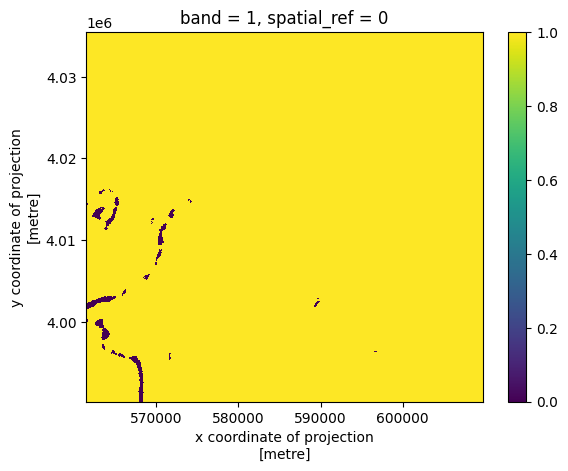

In [60]:
((swir16_clip/10_000) >= 0.1).plot()

In [61]:
swir16_clip

<xarray.DataArray (band: 1, y: 1131, x: 1208)> Size: 5MB
array([[[1066., 1067., ..., 1100., 1098.],
        [1066., 1066., ..., 1103., 1095.],
        ...,
        [1059., 1056., ..., 1008., 1007.],
        [1061., 1056., ..., 1002., 1006.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 10kB 5.615e+05 5.615e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 9kB 4.035e+06 4.035e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0